### Импорт всех необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import resnet34
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
from PIL import Image
from torchvision.transforms import functional as F


In [2]:
model = resnet34(weights='ResNet34_Weights.IMAGENET1K_V1', progress=False, )

In [3]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 3)
model = model.to(device)

### Ресайз, нормализация и аугументация

In [5]:
my_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((16, 16)),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)
my_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((16, 16)),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ]
)

### Чтение файлов в датасет и применения трансформаций

In [6]:
train_dataset = ImageFolder(root='train', transform=my_transform_train)
test_dataset = ImageFolder(root='val', transform=my_transform_test)

### Объявление даталоадеров

In [7]:
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
num_epochs = 16
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)

### Объявление loss функции

In [9]:
def loss_function(preds, true):
    loss = nn.CrossEntropyLoss()
    return loss(preds, true)

In [10]:
all_train_losses = []
all_test_losses = []

### Обучение и визуализация процесса обучения

loss train 0.8689488513129097
loss test 0.8612878918647766


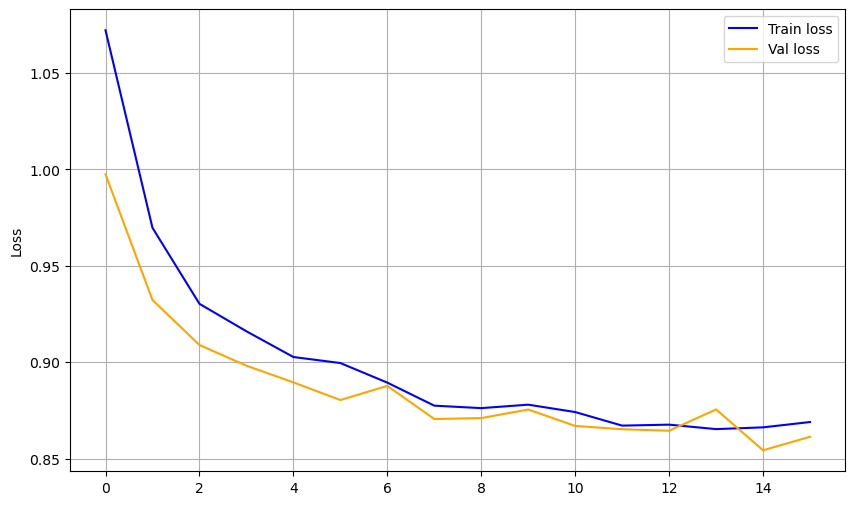

In [11]:
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    model.train(True)
    print(f'epoch_number is {epoch}. Train')
    for (X, y) in tqdm(train_dataloader):
        model.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()/(len(train_dataloader))
    model.eval()
    print(f'epoch_number is {epoch}. Test')
    for (X, y) in tqdm(test_dataloader):
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        test_loss += loss.detach().item()/(len(test_dataloader))
    clear_output()
    all_train_losses.append(train_loss)
    all_test_losses.append(test_loss)
    print('loss train', train_loss)
    print('loss test', test_loss)
    plt.figure(figsize = (10, 6))
    plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
    plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

### Вывод метрик модели

In [12]:
final_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [13]:
preds = []
real = []
for x, y in final_dataloader:
    preds.append(model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [14]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [15]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.57      0.60      0.58       500
           1       0.66      0.62      0.64       500
           2       0.66      0.68      0.67       500

    accuracy                           0.63      1500
   macro avg       0.63      0.63      0.63      1500
weighted avg       0.63      0.63      0.63      1500



### Предсказание на тесте 

In [16]:
dict_names = {
    0: 'Кошка',
    1: 'Собака',
    2: 'Дикая'
}

In [17]:
model.eval();

In [18]:
def predict_by_path(path):
    image = Image.open(path)
    image_np =  np.array(image)
    pred = model.forward(my_transform_train(image_np).to(device).unsqueeze(0)).cpu().detach().numpy()[0]
    plt.imshow(image)
    res = np.argmax(pred)
    print(dict_names[res])

Кошка


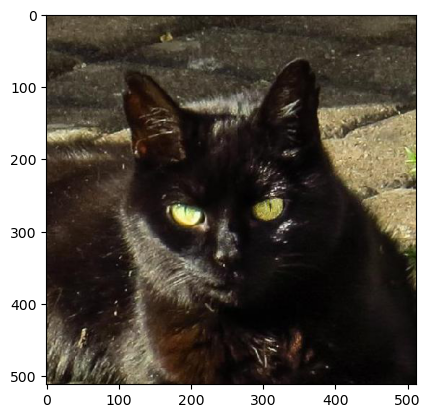

In [28]:
predict_by_path('val/cat/pixabay_cat_004662.jpg')

Собака


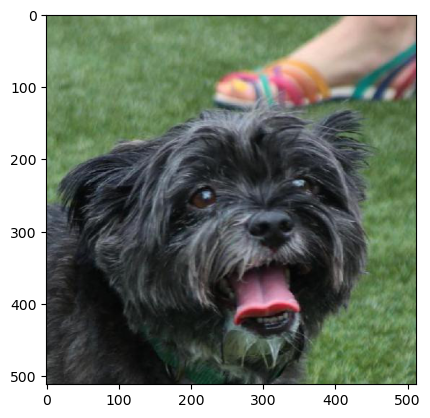

In [20]:
predict_by_path('val/dog/flickr_dog_000060.jpg')

Дикая


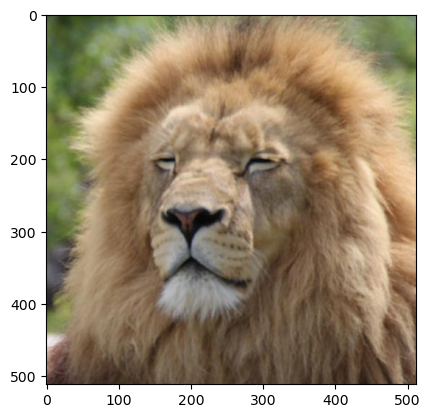

In [26]:
predict_by_path('val/wild/pixabay_wild_001224.jpg')